# Generacja tekstu imitującego twórczość Adama Mickiewicza

## Celem tego notebooka jest wytrenowanie sieci neuronowej, która imitowałaby twórczość Adama Mickiewicza.

Model jest rekurencyjną siecią neuronową (RNN). Rekurencyjne sieci neuronowe to klasa sieci neuronowych, która jest potężna w modelowaniu danych sekwencyjnych, takich jak szeregi czasowe lub język naturalny. Cechują się tym, że przechowują swój stan, który jest zmieniany przez dane wejściowe, i który ma wpływ na wyjście. 


Model generuje tekst litera po literze. Takie podejście ma znaczące zalety:
* nie korzystamy z word embeddingu, który ze względu na deklinację w języku polskim jest ogromny (wiele gigabajtów)
* nie ma problemów z nauczaniem nazw własnych, ani innych unikatowych słów wynikających m. in. z *licentia poetica*




Importuję potrzebne moduły

In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

Wczytuję tekst, który posłuży do nauczenia języka polskiego. Wybrałem tutaj trylogię sienkiewiczowską. Powodem tego jest to, iż twórczość Adama Mickiewicza ma zbyt małą objętość, aby sieć neuronowa nauczyła się imitować w miarę poprawnie język naturalny. Dość powiedzieć, iż sam *Pan Tadeusz* stanowi ponad ponad połowę tekstu przezeń napisanego, dlatego nie zadałem sobie nawet trudu uwzględnienia pozostałych dzieł. *Pan Tadeusz* ma około 500000 znaków, zaś trylogia sienkiewiczowska około 10 razy więcej, co powinno wystarczyć. 

**Uwaga!** Przed wczytaniem tekstu, należy usuniąć z niego egzotyczne, rzadko występujące znaki, których model nie jest w stanie się nauczyć. Wykonałem to w notebooku **text_preparation**. Należy się też upewnić, iż oba teksty mają taką samą liczbę unikatowych znaków, aby możliwe było przeuczunie sieci (transfer learning), a najlepiej byłoby, aby korzystały z dokładnie tych samych znaków. Zrobiłem to w notebooku **text_statistics**.

In [3]:
#text = open('sienkiewicz.txt', 'r', encoding='UTF-8').read()
text = open('drive/My Drive/Colab Notebooks/MickiewiczTextGeneration/sienkiewicz.txt', 'r', encoding='UTF-8').read()

Tworzę mapę znak->liczba, oraz liczba->znak, i koduję tekst jako ciąg liczb.

Tworzę obiekty dataset. Jeden będzie służyć do trenowania, a drugi to testowania.



In [4]:
vocab = sorted(set(text))
vocab_size = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

print(text_as_int[:20])

[25 40 47 42 38 46  1 42  1 46 42 38 36 56 38 46  0 18 38 47]


Dzielę zakodowany tekst na sekwencje.

In [5]:
seq_length = 192
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

Rozdzielam sekwencje na x i y, i dzielę dataset na batche.

In [6]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text
 
dataset = sequences.map(split_input_target)

BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Rozdzielam dataset na dataset treningowy i testowy.

In [7]:
BUFFER_SIZE = 1000
train_part = 0.99
DATASET_SIZE = len(sequences) // BATCH_SIZE
train_size = int(train_part * DATASET_SIZE)
test_size = int((1-train_part) * DATASET_SIZE)

train_dataset = dataset.take(train_size)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)



Tworzę funkcję generującą tekst. 

Działanie jest następujące:
* resetowanie stanu modelu
* pobranie z zbioru testowego danych, które posłużą za ziarno do dalszej generacji tekstu
* pętla generująca tekst, wykonuje się tyle razy, ile chemy znaków wygenerować

Działanie pętli generującej:

* dzielenie wyjścia z modelu przez temperaturę
* na podstawie otrzymanego wyniku wybierany jest częściowo losowo wygenerowany znak, im większa temperatura, tym większa losowość
* dodajemy nowy znak do wygenerowanego tekstu i karmimy tymże znakiem model

Tekst wygenerowany od ziarna odzielony jest przy pomocy znaku " | ".
Funkcja zwraca tyle tekstów, jaki jest rozmiar batch_size.




In [8]:
def generate_text(model, gen_length = 1000, temperature = 1.0):
    [(x,_)] = test_dataset.take(1)
    model.reset_states() 
    start_x = x
    
    x1 = x[:,:-1] 
    x2 = x[:,-1:] #last character
    
    model(x1)
    x = x2
    predictions = []  
    for i in range(gen_length):
        y = model(x)
        y = y / temperature
        y = tf.squeeze(y, axis=1)
        predicted_id = tf.random.categorical(y, num_samples=1)
        predictions.append(predicted_id.numpy())
        x = predicted_id

    texts = []
    for i in range( x.shape[0]):
        gen_text = ""
        for ix in start_x[i].numpy():
            gen_text += idx2char[ix]
            
        gen_text += "|"
        
        for j in range( len(predictions)):
            gen_text += idx2char[ predictions[j][i][0]]
        texts.append(gen_text)
    return texts

Buduję model sieci neuronowej.

Na wejściu znajduję się warstwa embedding. Jest to dość zaskakujące, gdyż model operuje na znakach, a nie słowach. Poradnik TensorFlow <a href="https://www.tensorflow.org/tutorials/text/text_generation">[1]</a> na którym się głównie wzorowałem nie opisuje dlaczego ta warstwa jest stosowana. Sprawdziłem wpływ tej warstwy w notebooku **embedding_test** i jak się okazało, rzeczywiście word embedding poprawia działanie. Im większy rozmiar embeddingu, tym nauczanie przebiega szybciej, jednak dla dużych rozmiarów różnica zanika. Tutaj wybrałem rozmiar 256.

Dalej mamy 3 warstwy LSTM, po których następują warstwy dropout.
Komórka LSTM ma 3 bramki: wejściową, wyjściową i zapominania; dzięki nim jest w stanie zarówno zapamiętymać zależności krótkotrwałe, jak i długotrwałe. Stąd też pochodzi nazwa - long short-term memory. Próbowałem też użyć komórek GRU, które są podobne, lecz nie mają wyjściowej bramki. Spisywały się jednak wyraźnie gorzej. 
Warstwy dropout pomagają przeciwdziałać przeuczeniu się modelu.

Na końcu znajduje się pojedyncza gęsta warstwa.


In [9]:
def build_model(vocab_size, batch_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 256, batch_input_shape=[batch_size, None]))
    model.add(tf.keras.layers.LSTM(1024, return_sequences=True, stateful=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(1024, return_sequences=True, stateful=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(1024, return_sequences=True, stateful=True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
    vocab_size=vocab_size,
    batch_size=BATCH_SIZE)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

Sprawdzam, czy model działa poprawnie.

In [10]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(input_example_batch.shape, " input shape")
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 192)  input shape
(32, 192, 72) # (batch_size, sequence_length, vocab_size)


Tworzę callback, który będzie wywoływany co *n* epok. Dzięki niemu zobaczymy jak model sobie radzi na różnych etapach uczenia.

In [11]:
class EpochEndCallback(tf.keras.callbacks.Callback):
    def __init__(self, n):
        self.n = n
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n == self.n-1:
            print("\n\n", generate_text(self.model,gen_length=100)[0],"\n")
        

Rozpoczynam uczenie.

In [12]:
EPOCHS = 10

#with tf.device('/cpu:0'):
with tf.device('/device:GPU:0'):
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks = [EpochEndCallback(1)])

Epoch 1/10
755/755 [==============================] - ETA: 0s - loss: 2.1812WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_test_batch_end` time: 0.0569s). Check your callbacks.


 rzyjść właśnie z chlebem do klasztoru, zostać nie tylko siostrzyczką, ale i karmicielką mniszek.

Miecznik wiedząc, że na chwałę bożą ma iść jego praca, pracował gorliwie. Objeżdżali więc raze|.

Atman nie po okszedźwało tysiężn wa wszela w przyjadych: i ja przejeszcza. I ladzie mura został?  

755/755 [==============================] - 172s 227ms/step - loss: 2.1812 - val_loss: 1.5658
Epoch 2/10
755/755 [==============================] - ETA: 0s - loss: 1.5087

 li Szwedów i Sakowiczowskich grasantów.

Oleńka wnet wzięła komendę nad opatrunkiem. Przytomna zawsze, pełna energii i siły, nie ustała w pracy póty, póki każdy ranny nie spoczął w chacie z pr|zywazionych decha blaski, inni zaś ostatnie roztojrzejąc obozie, lecz żeby znaków wąs, 

Generuję tekst o różnej różnorodności. 

In [13]:
texts1 = generate_text(model, temperature=0.7, gen_length=1000)
print(texts1[0])
print("\n-------------\n")

texts2 = generate_text(model, temperature=1.0, gen_length=1000)
print(texts2[0])
print("\n-------------\n")

texts3 = generate_text(model, temperature=1.3, gen_length=1000)
print(texts3[0])
print("\n-------------\n")

ujcie! A ty jej odpowiadasz: Nie pójdę! Biada wam! Biada takiemu narodowi, biada tej Rzeczypospolitej!

Tu panu Kmicicowi strach podniósł włosy na głowie i całe jego ciało dygotać poczęło, jak|by jej za głowę siłą go napadł nieruchomie.

- Żydzie! - rzekł książę. - Niech będzie mógł jeszcze siłę dusza pana miecznika rosieńskiego pod Warszawę w koronie i z ludźmi przeciw Rzeczypospolitej przenieść mogą.

- Nie chcę małą królewską mość znaczną naszego księcia Michała... Ale my tu się jeszcze wy i taki moje było w Rzeczypospolitej o wojnie i przed olechającymi pięściami widać było zdrowe, a wspomnienie poczęły cofnęć. Ran począł szybko przerażona i stanął w pędzie jeźdźców, zaraz ukazując się na dwóch stronach stawały się o stawo, nareszcie stało się ciemniej na świecie.

Po chwili pan miecznik był ciężkiej głosy, a pan Zagłoba porwał się w mgnieniu oka. Przed przyjacielem pan Zagłoba wychylił parę dni Bogusława z promieniejącym aksamitem.

- A czemu to ty, pana chorążego rodziciela ma sw

Można zapisać wygenerowany tekst do pliku.

In [14]:
with open("generated_text.txt", "w", encoding="utf-8") as f:
    for text in texts2:
        f.write(text)
        f.write("\n\n-------------------------------------------------------------\n\n")

Zapisuję model, aby móc go w przysłości wykorzystać.

In [15]:
model.save_weights("model")

Sprawdzam jak zmieniał się bład podczas uczenia, na zbiorze treningowym i testowym. Jak widać, nauczanie przebiegło poprawnie.

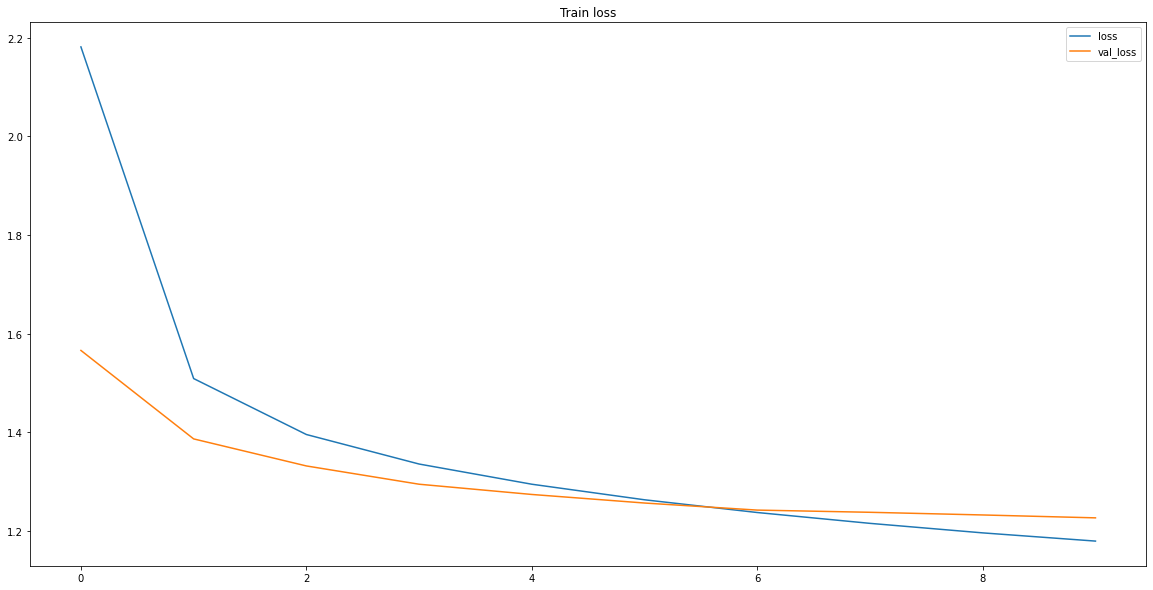

In [16]:
plt.figure(figsize=(20,10))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")

plt.legend()
plt.title("Train loss")
plt.show()

Następnym etapem jest przeuczenie modelu na twórczość Adama Mickiewicza. Jako że model "nauczył" się już języka polskiego, proces ten będzie niezwykle szybki.

In [19]:
#text = open('pan-tadeusz.txt', 'r', encoding='UTF-8').read()
text = open('drive/My Drive/Colab Notebooks/MickiewiczTextGeneration/pan-tadeusz.txt', 'r', encoding='UTF-8').read()

text_as_int = np.array([char2idx[c] for c in text])

examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
dataset = sequences.map(split_input_target)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

train_part = 0.95
DATASET_SIZE = len(sequences) // BATCH_SIZE
train_size = int(train_part * DATASET_SIZE)
test_size = int((1-train_part) * DATASET_SIZE)

train_dataset = dataset.take(train_size)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

EPOCHS = 4

#with tf.device('/cpu:0'):
with tf.device('/device:GPU:0'):
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks = [EpochEndCallback(1)])

Epoch 1/4
67/67 [==============================] - ETA: 0s - loss: 1.6776WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_test_batch_end` time: 0.0517s). Check your callbacks.


 eć, lecz milczy upornie;
On krok zwalnia, oczyma jej spojrzenia śledzi,
I zaśmiał się na koniec; rad z jej odpowiedzi
Stąpa prędzej, pogląda na rywalów z góry,
I swą konfederatkę z czaplinymi |krwawe rapy
Zielił tumult i zimny poseł nieco na łąkach.

 Ostrożnym lud chłopiący błyszczała oddała 

67/67 [==============================] - 17s 253ms/step - loss: 1.6776 - val_loss: 1.5549
Epoch 2/4
67/67 [==============================] - ETA: 0s - loss: 1.4888

 eć, lecz milczy upornie;
On krok zwalnia, oczyma jej spojrzenia śledzi,
I zaśmiał się na koniec; rad z jej odpowiedzi
Stąpa prędzej, pogląda na rywalów z góry,
I swą konfederatkę z czaplinymi |ją pełzać obrazyje.
Milczeć się pod wodzą Jęć lub moja cieplejana
Takie to krewne, że ich nie mo

Generuję tekst o różnej różnorodności i go zapisuję.

In [20]:
texts1 = generate_text(model, temperature=0.7, gen_length=1000)
print(texts1[0])
print("\n-------------\n")

texts2 = generate_text(model, temperature=1.0, gen_length=1000)
print(texts2[0])
print("\n-------------\n")

texts3 = generate_text(model, temperature=1.3, gen_length=1000)
print(texts3[0])
print("\n-------------\n")

with open("generated_text1.txt", "w", encoding="utf-8") as f:
    for text in texts1:
        f.write(text)
        f.write("\n\n-------------------------------------------------------------\n\n")
        
with open("generated_text2.txt", "w", encoding="utf-8") as f:
    for text in texts2:
        f.write(text)
        f.write("\n\n-------------------------------------------------------------\n\n")
        
with open("generated_text3.txt", "w", encoding="utf-8") as f:
    for text in texts3:
        f.write(text)
        f.write("\n\n-------------------------------------------------------------\n\n")

iada. Ja mam dosyć na tem,
Że mój Scyzoryk jeszcze zabłyśnie przed światem
W takim ręku! Niech tylko jenerał pamięta,
Aby tasiemka była długa, rozciągnięta,
Bo to długie; a zawsze od lewego uc|ha naszego rodu
Szkoda też przecież nikomu: jenerale, przyjmie o tobie, a teraz kopiec, ale jeszcze pod łaski mojego rodu,
Która się przed Tadeuszem słyszałem, potrzeba takiej głowy wywijać;
Czy nie może krzyczy młodzieńcem? ja waści gadałem...
I tobie mię wielkie zatrzymać zwykłe winy z Wielkopolanie.
Czy Sędzia - rzekł - przecież przed szeregiem błyszczała nad galenkiem.

 A tymczasem - rzekł Hrabia - jesteś wyzwaniem,
Czy ty szlachta z Zosi słychać było,
Nikt poły coraz to noc zgromadzać.
Tak rozumiał i słów nie można było zabawić,
I wyszedł Sędzia w Uszycy do szlacheckiej alteracji.
Ja tam szepnął. Dziś jest panienko! niech ten bardzo szczęśliwy!
Kto by to nie wiedział nikomu, przeto do przestawiać i twarzy,
Dobrze mój w tym chciał od waszej miłości służyć
Uprawić, że dzikie przykłady poznać 

Sprawdzam jak zmieniał się bład podczas uczenia, na zbiorze treningowym i testowym.

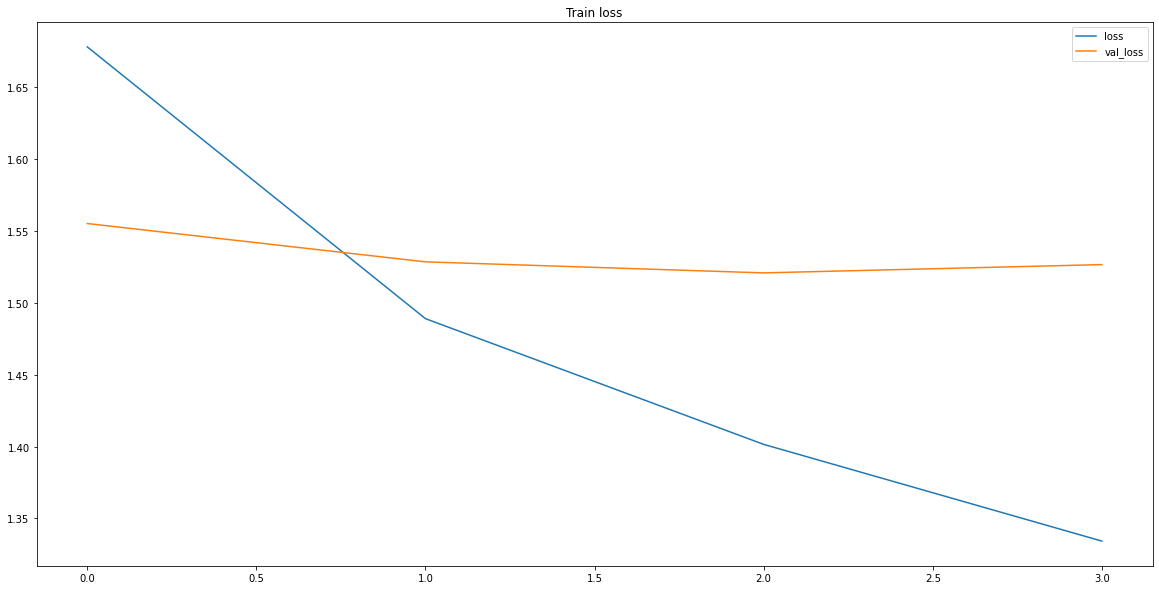

In [21]:
plt.figure(figsize=(20,10))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")

plt.legend()
plt.title("Train loss")
plt.show()

**Źródła**

Tworząc tego notebooka opierałem się głównie na tym poradniku <a href="https://www.tensorflow.org/tutorials/text/text_generation">https://www.tensorflow.org/tutorials/text/text_generation</a>.
Sprawdziłem również inne poradniki, jednak ten działał najlepiej, zwłaszcza, jeśli chodzi o długość wykonywania się pętli generującej tekst.

Jeśli chodzi o literaturę naukową, nie znalazłem żadnego artykułu, co pewnie wynika z trywialności zagadnienia. Znalazłem za to podobny problem <a href="https://arxiv.org/ftp/arxiv/papers/1901/1901.07426.pdf">https://arxiv.org/ftp/arxiv/papers/1901/1901.07426.pdf</a>, jednak tam model generuje tekst w oparciu o sylaby. Jeśli chodzi o sensowność generowanego tekstu, mój model okazał się lepszy.